In [29]:
import json
import regex as re
from collections import defaultdict
import matplotlib.pyplot as plt

file_path = 'data/tokens.json'
threshold=6
def load_tokens(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

In [39]:
def is_space_start_capital(token):
    return re.match(r'^([\s\u0120\u2581])([A-Z])', token) is not None

def is_space_start_lowercase(token):
    return re.match(r'^([\s\u0120\u2581])([^A-Z])', token) is not None
    
def is_space_start(token):
    return re.match(r'^([\s\u0120\u2581])', token) is not None

def has_replacement_bytes(token):
    return '�' in token

def is_code_related(token):
    code_pattern = re.compile(r'''
        [\{\}\[\]()<>]          # Brackets and parentheses
        | [!<>=]=?              # Comparison operators
        | [-+*/%]=?             # Arithmetic operators
        | &&|\|\||!             # Logical operators
        | \+\+|--               # Increment/decrement
        | ::|\->|\.\.\.         # Scope resolution, arrow, ellipsis
        | [&|^~]                # Bitwise operators
        | \\[nrt]               # Common escape sequences
        | ={2,}                 # Two or more equal signs (common in markup)
        | :\\                   # Backslash after colon (often in file paths)
        | [\\\/]                # Single backslash or forward slash
        | \w+://                # Protocol prefix http://
        | [\?\"\'\.]            # Question mark, double quote, single quote, period
    ''', re.VERBOSE)
    return code_pattern.search(token) is not None

def is_midword_short_token(token, threshold=threshold):
    return not re.match(r'^([\s\u0120\u2581])', token) and len(token) < threshold

def is_single_char(token):
    return len(token) == 1

def is_non_latin_char(token):
    return len(token) == 1 and ord(token) > 127

def is_control_word(token):
    control_words = ['<s>', '</s>', '<pad>', '<unk>', '<mask>', '<eos>', '<bos>']
    result = ((token in control_words) or
              (token.startswith('control_')) or
              (token.startswith('[') and token.endswith(']')))

    return result

def is_pure_unicode_byte(token):
    # Check if the token is a hexadecimal representation of a byte
    return bool(re.match(r'^<0x[0-9A-F]{2}>$', token))


In [40]:
def classify_tokens(tokens):
    filters = [
        ('control_words', is_control_word),
        ('replacement_bytes', has_replacement_bytes),
        ('pure_unicode_byte', is_pure_unicode_byte),
        ('non_latin_char', is_non_latin_char),
        ('single_char', is_single_char),
        ('code_related', is_code_related),
        # ('space_start_capital', is_space_start_capital),
        # ('space_start_lowercase', is_space_start_lowercase),
        ('space_start', is_space_start),
        ('mid_word', is_midword_short_token),
    ]

    stats = defaultdict(int)
    classified_tokens = defaultdict(set)

    for token in tokens:
        classified = False
        for group, filter_func in filters:
            if filter_func(token):
                stats[group] += 1
                classified_tokens[group].add(token)
                classified = True
                break

        if not classified:
            stats['other'] += 1
            classified_tokens['other'].add(token)

    return stats, classified_tokens



Sample tokens for each group:
control_words: ['[unused779]', '[control_23]', '[unused328]', '[unused352]', '[control_256]']
pure_unicode_byte: ['<0x45>', '<0x74>', '<0x75>', '<0x86>', '<0xE8>']
space_start: ['▁primeiro', 'ĠkÅĻ', 'Ġmodulates', 'Ġactu', 'Ġdigantikan']
mid_word: ['íĻ°', 'ÄĻ', 'ëĴ¤', 'moshe', 'θείτε']
code_related: ['}}{{\\', '?".', '-api', '-rad', '-border']
other: ['mackay', 'Nelson', 'beatable', 'dotted', 'è¯ķç®¡']
non_latin_char: ['🦍', '🫲', '入', '单', 'ย']
single_char: ['*', '\x19', '\x0c', '^', '\x05']
replacement_bytes: ['�', '��']


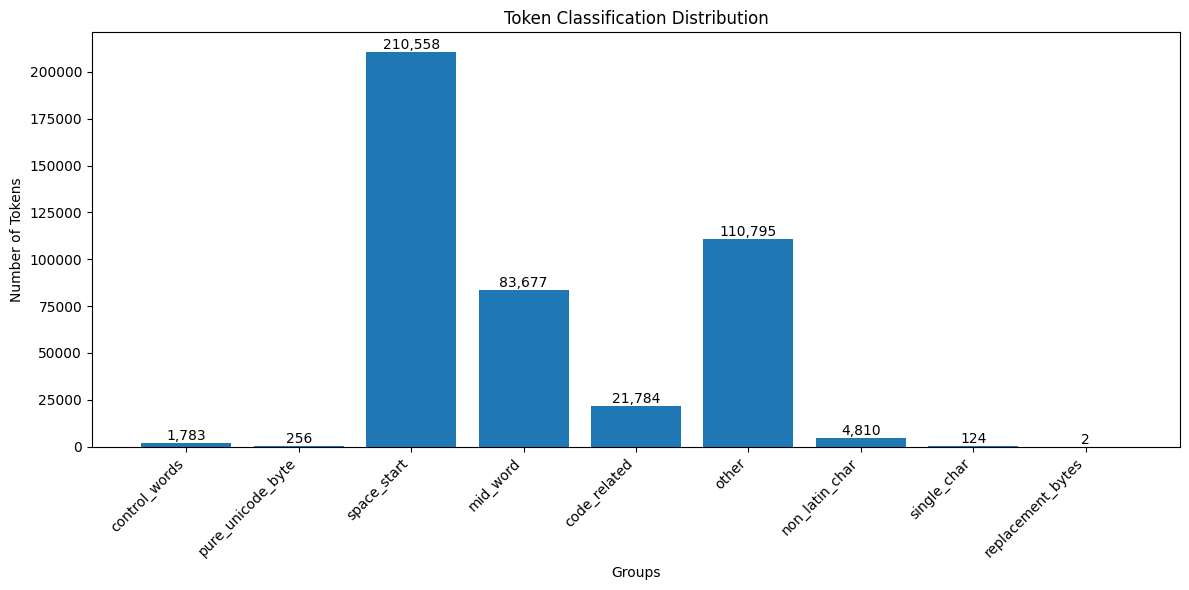

In [41]:
def plot_stats(stats):
    groups = list(stats.keys())
    values = list(stats.values())

    plt.figure(figsize=(12, 6))
    bars = plt.bar(groups, values)
    plt.title('Token Classification Distribution')
    plt.xlabel('Groups')
    plt.ylabel('Number of Tokens')
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:,}',
                 ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

token_data = load_tokens(file_path)
stats, classified_tokens = classify_tokens(token_data.keys())

# print("Token classification statistics:")
# for group, count in stats.items():
#     print(f"{group}: {count}")

print("\nSample tokens for each group:")
for group, tokens in classified_tokens.items():
    print(f"{group}: {list(tokens)[:5]}")

plot_stats(stats)

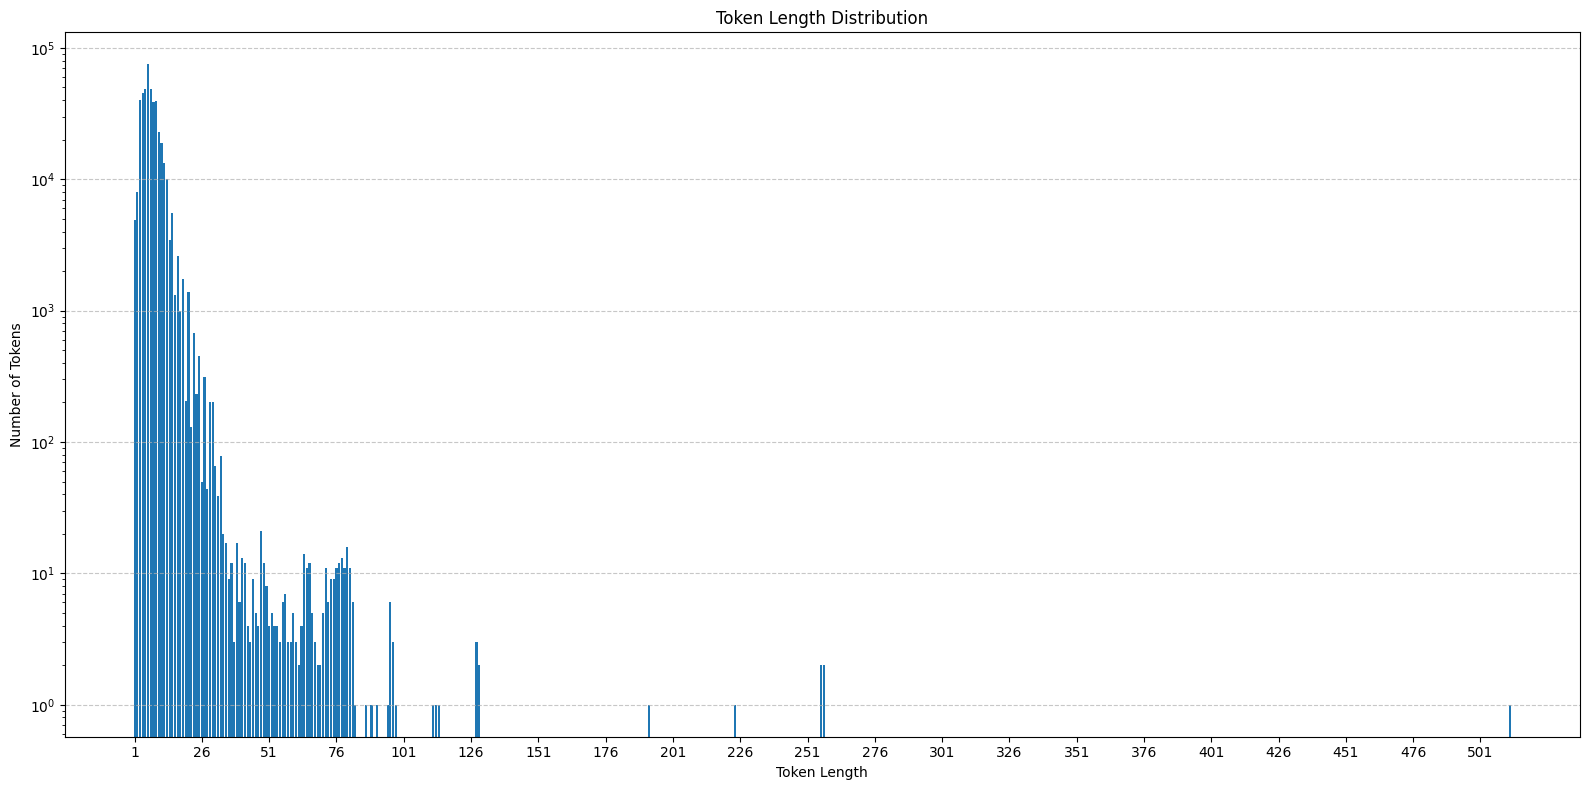


Token length statistics:
Shortest token length: 1
Longest token length: 512
Most common token length: 6
Number of unique token lengths: 100

Longest token(s):
Length 512: ĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠĠ

Token count for each length:
Length 1: 4935 tokens
Length 2: 8018 tokens
Length 3: 40042 tokens
Length 4: 45387 tokens
Length 5: 49015 tokens
Length 6: 74919 tokens
Length 7: 48309 tokens
Length 8: 38443 tokens
Length 9: 39606 tokens
Length 10: 22747 tokens
Length 11: 18905 tokens
Length 12: 13305 tokens
Length 1

In [28]:
def analyze_token_lengths(tokens):
    length_distribution = defaultdict(int)
    max_length = 0
    longest_tokens = []
    for token in tokens:
        token_length = len(token)
        length_distribution[token_length] += 1
        if token_length > max_length:
            max_length = token_length
            longest_tokens = [token]
        elif token_length == max_length:
            longest_tokens.append(token)

    # Remove lengths with zero counts
    length_distribution = {k: v for k, v in length_distribution.items() if v > 0}

    return length_distribution, longest_tokens

def plot_token_length_distribution(length_distribution):
    lengths = list(length_distribution.keys())
    counts = list(length_distribution.values())

    plt.figure(figsize=(16, 8))
    plt.bar(lengths, counts)
    plt.title('Token Length Distribution')
    plt.xlabel('Token Length')
    plt.ylabel('Number of Tokens')
    plt.xticks(range(min(lengths), max(lengths)+1, max(1, (max(lengths) - min(lengths)) // 20)))
    plt.yscale('log')  # Using log scale for better visualization
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


length_distribution, longest_tokens = analyze_token_lengths(token_data.keys())
plot_token_length_distribution(length_distribution)

print("\nToken length statistics:")
print(f"Shortest token length: {min(length_distribution.keys())}")
print(f"Longest token length: {max(length_distribution.keys())}")
print(f"Most common token length: {max(length_distribution, key=length_distribution.get)}")
print(f"Number of unique token lengths: {len(length_distribution)}")

print("\nLongest token(s):")
for token in longest_tokens:
    print(f"Length {len(token)}: {token}")

print("\nToken count for each length:")
for length, count in sorted(length_distribution.items()):
    print(f"Length {length}: {count} tokens")


Token byte parity statistics:
Tokens with even number of bytes: 267101
Tokens with odd number of bytes: 166688

Sample tokens with even number of bytes:
['</s>', '[INST]', '[TOOL_CALLS]', '[/AVAILABLE_TOOLS]', '[TOOL_RESULTS]']

Sample tokens with odd number of bytes:
['<unk>', '<s>', '[/INST]', '[AVAILABLE_TOOLS]', '[/TOOL_RESULTS]']


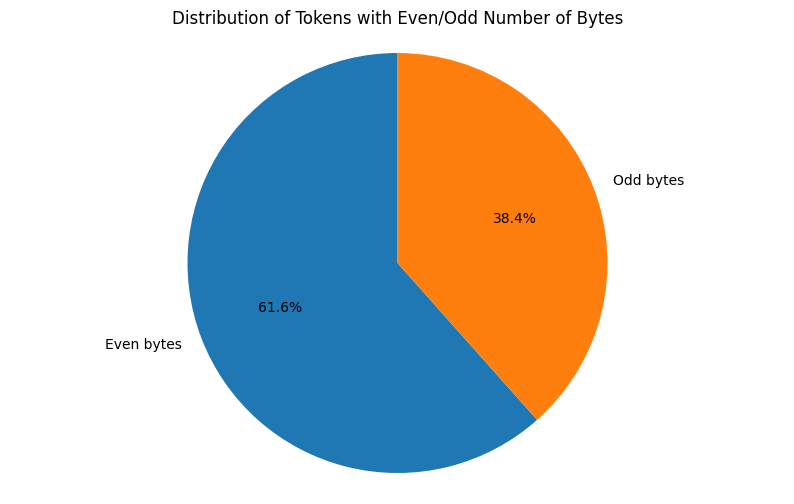

In [42]:
import json
import regex as re
from collections import defaultdict
import matplotlib.pyplot as plt

def analyze_token_byte_parity(tokens):
    even_bytes = 0
    odd_bytes = 0
    even_byte_tokens = []
    odd_byte_tokens = []

    for token in tokens:
        byte_count = len(token.encode('utf-8'))
        if byte_count % 2 == 0:
            even_bytes += 1
            even_byte_tokens.append(token)
        else:
            odd_bytes += 1
            odd_byte_tokens.append(token)

    return {
        'even': even_bytes,
        'odd': odd_bytes,
        'even_tokens': even_byte_tokens,
        'odd_tokens': odd_byte_tokens
    }

def plot_byte_parity_distribution(parity_stats):
    labels = ['Even bytes', 'Odd bytes']
    sizes = [parity_stats['even'], parity_stats['odd']]

    plt.figure(figsize=(10, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Distribution of Tokens with Even/Odd Number of Bytes')
    plt.show()


byte_parity_stats = analyze_token_byte_parity(token_data.keys())

print("\nToken byte parity statistics:")
print(f"Tokens with even number of bytes: {byte_parity_stats['even']}")
print(f"Tokens with odd number of bytes: {byte_parity_stats['odd']}")

print("\nSample tokens with even number of bytes:")
print(byte_parity_stats['even_tokens'][:5])

print("\nSample tokens with odd number of bytes:")
print(byte_parity_stats['odd_tokens'][:5])

plot_byte_parity_distribution(byte_parity_stats)